# Dengue Fever Prediction 

## Background
Dengue Fever is a mosquito-borne viral infection that causes fever, rash, headache, and muscle pain. It is most common in tropical and sub-tropical regions, where climate conditions support mosquito populations.

DataDriven is a Kaggle-like website that collects data sets and creates challenges. The [DengAI challenge from DataDriven](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/data/) has collected data on dengue cases and environmental variables such as temperature and precipitation.

Make an account on DataDriven and download the DengAI data. Look at the competition information to understand the features of the data. 

Load the training data. Remove feature columns that we won't use for prediction: city, year, and week start date. Replace any missing values with mean values. 

In [10]:
# Import packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error

In [11]:
# Functions that imputes NaN values with the mean score of each column
def imputeMean(df):

    # Find columns with missing values to find mean and impute
    null_col = df.columns[df.isnull().any()].tolist()
    
    # Fill null values with the mean value of the column
    for col in null_col:
        df[col].fillna(int(df[col].mean()), inplace=True)

# Function to produce .csv from dataframe 
def toCSV(df, output_name):

    # Save all the model predictions for total_cases as a .csv file
    filename = output_name

    # dataframe to csv
    df.to_csv(filename, index=False)

In [12]:
# Import train and test data 

# data .csv paths
train_path = 'data/dengue_features_train.csv'
test_path = 'data/dengue_features_test.csv'
labels_path = 'data/dengue_labels_train.csv'

# import data as pandas dataframe
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
labels_df = pd.read_csv(labels_path)

In [13]:
# Remove feature columns that will not be used for prediction: city, year and week start date from train & test data 
feature_df = train_df.drop(['city', 'year', 'week_start_date'], axis=1)
CLtest_df = test_df.drop(['city', 'year', 'week_start_date'], axis=1)
labels_df = labels_df.drop(['city', 'year', 'weekofyear'], axis=1)

In [14]:
# impute NaN values with mean values in each column 
imputeMean(feature_df)
imputeMean(CLtest_df)

## Linear Regression Model
Divide the training data into a training set (80% of the data) and a validation set (20%) *Hint: make sure you do these the same way for the features and labels*. You will use the validation set to compare performance across models. 

In [15]:
# Split train data into features and validation sets 
X_train, X_test, y_train, y_test = train_test_split(feature_df, labels_df, test_size=0.2, random_state=0)

Train a linear regression model on the training data and evaluate its performance on the validation set according to the mean absolute error. Make a scatter plot of the predicted and true case counts for the validation set.  

In [16]:
# Data Preprocessing
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

# Train a linear regression model on the training data 
model = LinearRegression()
model.fit(X_train, y_train)

# Prediction values 
y_pred = model.predict(X_test)

# Mean Absolute Error Validation
MAE = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error for Linear Regression Model: {MAE:.2f}")

Mean Absolute Error for Linear Regression Model: 22.96


### Scatterplot of Predicted and True Case Counts

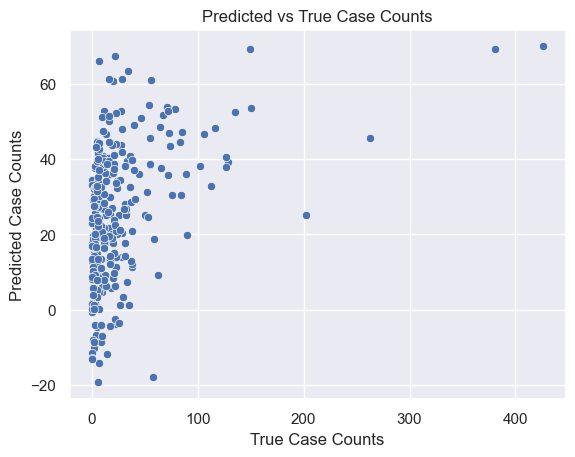

In [17]:
# Reformat predicted cases in a dataframe & reset indices 
y_pred = pd.DataFrame(y_pred, columns=['total_cases'])
y_pred.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Set seaborn figure
sns.set(style="darkgrid")

# Scatterplot 
sns.scatterplot(x=y_test['total_cases'], y=y_pred['total_cases'])
plt.xlabel("True Case Counts")
plt.ylabel("Predicted Case Counts")
plt.title("Predicted vs True Case Counts")
plt.show()

# Extra Credit: Poisson GLM & Multi-Layer Perceptron Models
**Extra Credit**: Use [scikit-learn's Poisson GLM method](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html) on this data. Report mean absolute error on the validation set. Explain why this model is more appropriate than linear regression for this task. 

## Poisson GLM Model

In [18]:
# Instantiate GLM model & train model on the training data
glm_model = PoissonRegressor(alpha=1.0, max_iter=100)
glm_model.fit(X_train, y_train.values.reshape(-1))

# Create Prediction Values
y_pred = glm_model.predict(X_test)

# Mean Absolute Error Validation 
GLM_MAE = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error for Poisson GLM model: {GLM_MAE:.2f}")

Mean Absolute Error for Poisson GLM model: 20.38


### Why is this model more appropriate than linear regression for this task?
The Poisson GLM Model is more appropriate for this data set than a Linear Regression Model because the dependent variable (total_cases) is count data. The Poisson GLM Model can be more appropriate than a Linear Regression Model for count data because it is specifically designed to handle count data and can capture non-linear relationships between the independent and dependent variables. Count data is typically violates assumptions of linear regression by because the distribution of counts is typically skewed and the variance is proportional to the mean. On the other hand, Linear regression assumes that the dependent variable is normally distributed, and that the variance of the dependent variable is constant across all levels of the independent variables.

## Multi-Layer Perceptron Model
Here you will train an artificial neural network to perform this task. You can use the [multi-layer perceptron model](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html), which is a simple feedforward neural network. You can vary the architecture of the network using the hidden_layer_sizes parameter. 

Try out at least 3 different depths (number of hidden layers) and 3 different widths (number of units in each layer). Pick the model that performs the best on the validation set and upload its predictions on the test set to the DataDriven competition page according to the provided submission format. Include a screenshot of your performance. Do the same for the model that performed the worst on the validation set. Does validation performance relate to test performance for you? 

*Note: the submission requires total_cases be an integer*

In [19]:
# Create dataframe with depths (columns) and widths (rows)
score_table = pd.DataFrame(columns=[100, 200, 300, 400, 500],
                           index=[2, 4, 6, 8, 10])

# For loop to test different depths and widths in Multi-Layer Perceptron Model 
for width in [2, 4, 6, 8, 10]:

    # Instantiate empty list for depth score per width (row in the dataframe)
    depth_score = []

    # Loop through each depth
    for depth in [100, 200, 300, 400, 500]:

        # Instantiate Multi-Layer Perceptron Model 
        nn_model = MLPRegressor(hidden_layer_sizes=(
            depth,) * width, random_state=0, max_iter=2000)
        nn_model.fit(X_train, y_train.values.reshape(-1))

        # Get score of the model 
        score = nn_model.score(X_test, y_test)

        # Append to list
        depth_score.append(score)


    # Add row to dataframe 
    score_table.loc[width] = depth_score

In [20]:
# Let's take a look at the score table
score_table

100       200       300       400       500
2   0.390707  0.469779  0.475871  0.533697  0.514801
4   0.553002  0.608904  0.566556  0.591144  0.629916
6   0.540132  0.475353  0.606409  0.611406  0.632177
8    0.54626  0.582569  0.614362  0.594086  0.511159
10  0.552237   0.61912  0.573045   0.56565  0.643988

It seems that the **best model** has a depth of $500$ and a width of $10$. The **worst model** has a depth of $100$ and a width of $2$.

### Create Output with the Best Multi-Layer Perceptron Model

In [21]:
# Preprocess test data 
X_test = sc_x.transform(CLtest_df)

# Instantiate & train best NN Model 
nn_model = MLPRegressor(hidden_layer_sizes=(
    500,) * 10, random_state=0, max_iter=2000)
nn_model.fit(X_train, y_train.values.reshape(-1))

# Predicted Values
y_pred = nn_model.predict(X_test)

In [22]:
# Reformat predicted values into proper output format dataframe
y_pred = pd.DataFrame(y_pred, columns=['total_cases'])
submit = pd.concat([test_df.iloc[:, :3], y_pred], axis=1).astype({"total_cases": int})

# Output dataframe to .csv
toCSV(submit, "best_output.csv")

### Model Performance on DataDriven
![BestModelPerformance](GraphsTablesImages/best_output_score.png)

### Create Output with the Worst Multi-Layer Perceptron Model

In [23]:
# Instantiate & train worst NN Model 
nn_model = MLPRegressor(hidden_layer_sizes=(
    100,) * 2, random_state=0, max_iter=2000)
nn_model.fit(X_train, y_train.values.reshape(-1))

# Predicted Values 
y_pred = nn_model.predict(X_test)

In [24]:
# Reformat predicted values into proper output format dataframe 
y_pred = pd.DataFrame(y_pred, columns=['total_cases'])
submit = pd.concat([test_df.iloc[:, :3], y_pred],
                   axis=1).astype({"total_cases": int})

# Output dataframe to .csv
toCSV(submit, "worst_output.csv")

### Worst Model Performance on DataDriven 
![WorstModelPerformance](GraphsTablesImages/worst_output_score.png)

### Does validation performance relate to test performance for you?
Yes, the validation performance relates to test performance in my case. The better validation performing Multi-Layered Perceptron model (500 depth, 10 width) had a lower (better) test performance score on DataDriven compared to the worse validation performing Multi-Layered Perceptron model (100 depth, 2 width). 